<h1> Uber & Lyft Data Analysis and Price Prediction</h1>

In this notebook, we will explore and visualize two ride sharing datasets sourced from Uber and Lyft. The datasets contain data about individual rides booked over these platforms. Based on this data, we will also conduct a price prediction using some machine and deep learning algorithms which could be used in a pricing strategy.

The two datasets we will be using are:

*   [Uber Pickups in NYC](https://www.kaggle.com/datasets/fivethirtyeight/uber-pickups-in-new-york-city)
  *   Contains uber trip data from 2014 (April - September), separated by month, with detailed location information
  *   Includes only the longitude and latitude of the pickup location and the date and time of pickup


*   [Uber & Lyft Boston Dataset](https://www.kaggle.com/datasets/brllrb/uber-and-lyft-dataset-boston-ma)
  * Contains Uber and Lyft trip data from 26th November 2018 to 18th December 2018
  * Includes lots of additional data such as price of the ride, vehicle type, temperature at the time of the ride, precipitation etc.
  * Unfortunately, longitude and latitude are aggregated into very coarse-grained areas


# Setup

## Environment Setup

To begin, we need to install a data visualization and projection library which is not available under Colab by default:

In [ ]:
!pip install datashader pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.2 MB 85 kB/s 
     |████████████████████████████████| 7.8 MB 19.9 MB/s 
     |████████████████████████████████| 76 kB 2.5 MB/s 
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59439 sha256=d4c12fb09320da24ae224d6c9e03b5a6f9aaa0a8eaa1c1c20da70e20ac51a2f3
  Stored in directory: /root/.cache/pip/wheels/6d/79/c4/c425774559165f472d32e5ef592ff9a71179abb31f05dbc98b
Successfully built datashape


We can also import the libraries we are going to use:

In [ ]:
import pandas as pd
import glob
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import plotly.express as px
from pyproj import Transformer
import datashader as ds
from colorcet import fire
from datashader import transfer_functions
import plotly.express as px
import seaborn as sns
import geopy.distance
import numpy as np
import math
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Download Data

Let's start by downloading and unzipping the two datasets from Azure:

In [ ]:
!wget -nc https://exercisesmlstorage.blob.core.windows.net/deep-learning/uber_dataset.zip

--2022-12-15 10:12:57--  https://exercisesmlstorage.blob.core.windows.net/deep-learning/uber_dataset.zip
Resolving exercisesmlstorage.blob.core.windows.net (exercisesmlstorage.blob.core.windows.net)... 20.38.118.132
Connecting to exercisesmlstorage.blob.core.windows.net (exercisesmlstorage.blob.core.windows.net)|20.38.118.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114370464 (109M) [application/x-zip-compressed]
Saving to: ‘uber_dataset.zip’

uber_dataset.zip    100%[===================>] 109.07M  8.57MB/s    in 25s     

2022-12-15 10:13:22 (4.34 MB/s) - ‘uber_dataset.zip’ saved [114370464/114370464]



In [ ]:
!unzip -n uber_dataset.zip

Archive:  uber_dataset.zip
  inflating: Uber-Jan-Feb-FOIL.csv   
  inflating: other-American_B01362.csv  
  inflating: other-Carmel_B00256.csv  
  inflating: other-Dial7_B00887.csv  
  inflating: other-Diplo_B01196.csv  
  inflating: other-FHV-services_jan-aug-2015.csv  
  inflating: other-Federal_02216.csv  
  inflating: other-Firstclass_B01536.csv  
  inflating: other-Highclass_B01717.csv  
  inflating: other-Lyft_B02510.csv   
  inflating: other-Prestige_B01338.csv  
  inflating: other-Skyline_B00111.csv  
  inflating: uber-raw-data-apr14.csv  
  inflating: uber-raw-data-aug14.csv  
  inflating: uber-raw-data-janjune-15.csv  
  inflating: uber-raw-data-jul14.csv  
  inflating: uber-raw-data-jun14.csv  
  inflating: uber-raw-data-may14.csv  
  inflating: uber-raw-data-sep14.csv  


In [ ]:
!wget -nc https://exercisesmlstorage.blob.core.windows.net/deep-learning/uber_lyft_dataset.zip

--2022-12-15 10:13:28--  https://exercisesmlstorage.blob.core.windows.net/deep-learning/uber_lyft_dataset.zip
Resolving exercisesmlstorage.blob.core.windows.net (exercisesmlstorage.blob.core.windows.net)... 20.38.118.132
Connecting to exercisesmlstorage.blob.core.windows.net (exercisesmlstorage.blob.core.windows.net)|20.38.118.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46647617 (44M) [application/x-zip-compressed]
Saving to: ‘uber_lyft_dataset.zip’

uber_lyft_dataset.z 100%[===================>]  44.49M  8.67MB/s    in 6.1s    

2022-12-15 10:13:35 (7.35 MB/s) - ‘uber_lyft_dataset.zip’ saved [46647617/46647617]



In [ ]:
!unzip -n uber_lyft_dataset.zip

Archive:  uber_lyft_dataset.zip
  inflating: rideshare_kaggle.csv    


## Load Data

Next, we load our datasets as pandas dataframes.

### Uber

For the Uber dataset, the data is split over several CSV files (one for each month) so we will first load all files individually and then concat them:

In [ ]:
files_2014 = glob.glob(r'uber-raw-data-*14.csv')

li = [pd.read_csv(filename, index_col=None, header=0, parse_dates=['Date/Time'], infer_datetime_format=True) for filename in tqdm(files_2014)]

# we also sort the data here by the date/time in case the files are mixed up
uber_df = pd.concat(li, axis=0, ignore_index=True).sort_values('Date/Time')

  0%|          | 0/6 [00:00<?, ?it/s]

Using the `shape` property, we can see that the dataset contains about 4.5 million datapoints and 4 columns:

In [ ]:
uber_df.shape

(4534327, 4)

Let's have a first look at the data:

In [ ]:
uber_df.sample(10)

Date/Time      Lat      Lon    Base
4484731 2014-09-24 17:53:00  40.7088 -74.0076  B02764
3904309 2014-09-10 15:59:00  40.7264 -73.9958  B02617
823906  2014-07-18 20:19:00  40.7436 -74.0072  B02598
2152675 2014-06-13 13:12:00  40.7514 -73.9754  B02598
2371759 2014-06-15 19:03:00  40.7458 -73.9939  B02617
3670398 2014-09-16 19:21:00  40.7550 -73.9899  B02598
2811727 2014-08-14 15:19:00  40.7567 -73.9786  B02598
1332790 2014-07-15 22:24:00  40.7679 -73.9533  B02682
3733585 2014-09-24 18:38:00  40.7049 -74.0115  B02598
2235967 2014-06-24 11:48:00  40.7626 -73.9654  B02598

The columns have the following meaning:


*   `Date/Time`: date and time of pickup
*   `Lat`: latitude of pickup location
*   `Lon`: longitude of pickup location
*   `Base`: the TLC base company code affiliated with the Uber pickup (not relevant for us)



### Uber & Lyft

The Uber & Lyft dataset only consists of one CSV file so we can just load it using the `read_csv` function:

In [ ]:
# we also remove some redundant columns (the information contained in these colums are also present in the "datetime" column)
uber_lyft_df = pd.read_csv('rideshare_kaggle.csv', parse_dates=['datetime']).drop(columns=['timestamp', 'hour', 'day', 'month', 'timezone'])

This data contains 693.000 datapoints and 52 columns:

In [ ]:
uber_lyft_df.shape

(693071, 52)

We will also look at this dataset:

In [ ]:
uber_lyft_df.sample(10)

id            datetime  \
685095  1b106b4f-ffcc-4a7e-b3b2-33a2956f1113 2018-12-01 19:08:02   
409610  462d17c5-15af-4ccf-a428-732b584c345c 2018-12-15 04:10:08   
677762  53e70de9-841a-4a12-b58b-f66b2ace53f8 2018-11-27 13:33:23   
610740  22ba9e13-40e6-4d3e-b742-d80d8db2196b 2018-12-02 17:52:56   
292042  22fdfafd-70f5-42a4-b890-e430a15c7af9 2018-12-02 18:33:00   
105742  e73703a0-5b8f-41aa-b409-d335869e931e 2018-11-28 16:35:07   
142667  db9ecff9-0145-4156-820d-1a3442aa1be2 2018-12-14 10:30:09   
253113  cf27b17e-0db3-49ad-877a-8f25c95e1fec 2018-11-29 06:28:05   
678712  c117577f-e840-47b0-a239-d626f6ac79b9 2018-12-13 13:45:11   
649000  75d93b13-3b85-46f6-890e-55a47dcba771 2018-12-15 18:50:13   

                   source         destination cab_type  \
685095             Fenway            West End     Uber   
409610  Boston University  Financial District     Uber   
677762          North End  Financial District     Uber   
610740   Haymarket Square         Beacon Hill     Uber   
292042   Theatre District       South Station     Uber   
105742             Fenway    Theatre District     Uber   
142667             Fenway            West End     Lyft   
253113          North End       North Station     Uber   
678712   Theatre District              Fenway     Lyft   
649000   Theatre District       South Station     Lyft   

                                  product_id      name  price  distance  \
685095  55c66225-fbe7-4fd5-9072-eab1ece5e23e     UberX    9.5      2.72   
409610  997acbb5-e102-41e1-b155-9df7de0a73f2  UberPool   10.0      4.72   
677762  9a0e7b09-b92b-4c41-9779-2ad22b4d779d       WAV    9.5      1.04   
610740  8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a      Taxi    NaN      1.36   
292042  9a0e7b09-b92b-4c41-9779-2ad22b4d779d       WAV    7.0      0.55   
105742  997acbb5-e102-41e1-b155-9df7de0a73f2  UberPool   10.0      2.38   
142667                             lyft_line    Shared   11.0      2.83   
253113  9a0e7b09-b92b-4c41-9779-2ad22b4d779d       WAV    7.0      1.03   
678712                                  lyft      Lyft   13.5      4.30   
649000                          lyft_premier       Lux   19.5      0.68   

        surge_multiplier  ...  precipIntensityMax  uvIndexTime  \
685095              1.00  ...              0.0000   1543683600   
409610              1.00  ...              0.0000   1544806800   
677762              1.00  ...              0.1429   1543338000   
610740              1.00  ...              0.0916   1543770000   
292042              1.00  ...              0.0894   1543770000   
105742              1.00  ...              0.0000   1543420800   
142667              1.00  ...              0.0000   1544806800   
253113              1.00  ...              0.0000   1543510800   
678712              1.00  ...              0.0001   1544716800   
649000              1.75  ...              0.0077   1544893200   

        temperatureMin  temperatureMinTime temperatureMax temperatureMaxTime  \
685095           31.55          1543658400          44.72         1543690800   
409610           26.93          1544788800          46.68         1544814000   
677762           36.37          1543377600          47.06         1543320000   
610740           36.32          1543726800          50.80         1543788000   
292042           36.40          1543726800          50.94         1543788000   
105742           33.75          1543399200          42.60         1543438800   
142667           27.05          1544781600          46.67         1544814000   
253113           35.35          1543550400          44.61         1543510800   
678712           18.05          1544688000          33.92         1544731200   
649000           39.80          1544929200          54.29         1544896800   

        apparentTemperatureMin  apparentTemperatureMinTime  \
685095                   27.95                  1543658400   
409610                   27.58                  1544788800   
677762                   32.40    

In [ ]:
uber_lyft_df.columns

Index(['id', 'datetime', 'source', 'destination', 'cab_type', 'product_id',
       'name', 'price', 'distance', 'surge_multiplier', 'latitude',
       'longitude', 'temperature', 'apparentTemperature', 'short_summary',
       'long_summary', 'precipIntensity', 'precipProbability', 'humidity',
       'windSpeed', 'windGust', 'windGustTime', 'visibility',
       'temperatureHigh', 'temperatureHighTime', 'temperatureLow',
       'temperatureLowTime', 'apparentTemperatureHigh',
       'apparentTemperatureHighTime', 'apparentTemperatureLow',
       'apparentTemperatureLowTime', 'icon', 'dewPoint', 'pressure',
       'windBearing', 'cloudCover', 'uvIndex', 'visibility.1', 'ozone',
       'sunriseTime', 'sunsetTime', 'moonPhase', 'precipIntensityMax',
       'uvIndexTime', 'temperatureMin', 'temperatureMinTime', 'temperatureMax',
       'temperatureMaxTime', 'apparentTemperatureMin',
       'apparentTemperatureMinTime', 'apparentTemperatureMax',
       'apparentTemperatureMaxTime'],
      dty

We have many more columns, for example:


*   `name`: name of the type of service booked (Uber and Lyft offer standard and more premium ridesharing services, differing mainly by the type of car)
*   `price`: the price of the ride (we will use this later for price prediction)
*   `distance`: distance of the ride
*   `surge_multiplier`: a factor that indicates how much demand the platform currently receives (see [How surge pricing works](https://www.uber.com/us/en/drive/driver-app/how-surge-works/))
*   `apparentTemperature`: the "felt" temperature at the time of pickup
*   `precipIntensity`: intensity of precipitation at the time of pickup



# Data Cleansing

As a first data processing step, we conduct some very simple data cleansing. In particular, we will handle missing values, irrelevant columns and inconsistent data. Of course, many more steps could be conducted here.

## Remove Irrelevant Data

For our analysis, we will only be using a subset of the available data. In this step, we remove all columns which will not be needed.

### Uber

For the Uber dataset, we only remove the `Base` column:

In [ ]:
uber_df = uber_df.drop(columns='Base')

### Uber & Lyft

For this dataset, we will remove all columns except for the `cab_type`, `name`, `price`, `distance`, `surge_multiplier`, `temperature`, `apparentTemperature`, `precipIntensity`, `windSpeed` and `uvIndex` columns.

In [ ]:
uber_lyft_df = uber_lyft_df[['datetime', 'cab_type', 'name', 'price', 'distance', 'surge_multiplier', 'temperature', 'apparentTemperature', 'precipIntensity', 'windSpeed', 'uvIndex']]

## Handle Missing Values

### Uber

Let's check how many missing values we have in our dataset:

In [ ]:
uber_df.isna().sum().sum()

0

No missing values, nothing to do!

### Uber & Lyft

The second dataset does contain around 55k missing values.

In [ ]:
uber_lyft_df.isna().sum().sum()

55095

We can handle this by just removing the corresponding rows:

In [ ]:
uber_lyft_df = uber_lyft_df.dropna()

Let's check again:

In [ ]:
uber_lyft_df.isna().sum().sum()

0

## Check for Inconsistent Data

### Uber

For the Uber dataset, we might check if the latitudes and longitudes contained are somewhere around the NY area.

In [ ]:
uber_df.describe()

Lat           Lon
count  4.534327e+06  4.534327e+06
mean   4.073926e+01 -7.397302e+01
std    3.994991e-02  5.726670e-02
min    3.965690e+01 -7.492900e+01
25%    4.072110e+01 -7.399650e+01
50%    4.074220e+01 -7.398340e+01
75%    4.076100e+01 -7.396530e+01
max    4.211660e+01 -7.206660e+01

In [ ]:
max_lat = uber_df.Lat.max()

In [ ]:
max_lon = uber_df.Lon.max()

In [ ]:
min_lat = uber_df.Lat.min()

In [ ]:
min_lon = uber_df.Lon.min()

Now we can retrieve the data points which make up these "extreme" values:

In [ ]:
extreme_df = uber_df[(uber_df.Lat == max_lat) | (uber_df.Lat == min_lat) | (uber_df.Lon == max_lon) | (uber_df.Lon == min_lon)]

In [ ]:
extreme_df

Date/Time      Lat      Lon
1586129 2014-04-20 08:32:00  42.1166 -72.0666
211656  2014-05-21 12:51:00  40.3928 -74.9290
2715148 2014-08-01 19:32:00  39.6569 -74.2258

Let's plot the min and max latitudes and longitudes

In [ ]:
fig = px.scatter_mapbox(extreme_df, lat='Lat', lon='Lon', zoom=6)
fig.update_layout(mapbox_style="carto-positron")
fig.show()

These points are all in the greater NY area, so they seem to be consistent.

Another thing we might check is if the `Date/Time` column is within the expected timespan:

In [ ]:
uber_df['Date/Time'].min(), uber_df['Date/Time'].max()

(Timestamp('2014-04-01 00:00:00'), Timestamp('2014-09-30 22:59:00'))

All values are between 1st of April and 30th of September, right what we expect.

### Uber & Lyft

For the Uber & Lyft dataset, we can conduct many more inconsistency checks. Let's again start by looking at some interesting statistics:

In [ ]:
uber_lyft_df.describe()

price       distance  surge_multiplier    temperature  \
count  637976.000000  637976.000000     637976.000000  637976.000000   
mean       16.545125       2.189261          1.015068      39.582406   
std         9.324359       1.135413          0.095422       6.725500   
min         2.500000       0.020000          1.000000      18.910000   
25%         9.000000       1.270000          1.000000      36.450000   
50%        13.500000       2.160000          1.000000      40.490000   
75%        22.500000       2.930000          1.000000      43.580000   
max        97.500000       7.860000          3.000000      57.220000   

       apparentTemperature  precipIntensity      windSpeed        uvIndex  
count         637976.00000    637976.000000  637976.000000  637976.000000  
mean              35.87844         0.008909       6.186795       0.249031  
std                7.91726         0.026880       3.147856       0.474306  
min               12.13000         0.000000       0.450000       0.000000  
25%               31.91000         0.000000       3.410000       0.000000  
50%               35.90000         0.000000       5.910000       0.000000  
75%               40.01000         0.000000       8.410000       0.000000  
max               57.22000         0.144700      15.000000       2.000000

All of these values seem to be in an expected range (though the temperature seems a bit low for Fahrenheit).

We might also check the values of the `cab_type` and `name` columns:

In [ ]:
uber_lyft_df.cab_type.value_counts()

Uber    330568
Lyft    307408
Name: cab_type, dtype: int64

In [ ]:
uber_lyft_df.name.value_counts()

UberXL          55096
WAV             55096
Black SUV       55096
Black           55095
UberX           55094
UberPool        55091
Lux             51235
Lyft            51235
Lux Black XL    51235
Lyft XL         51235
Lux Black       51235
Shared          51233
Name: name, dtype: int64

Seems all ok!

This conducts our data cleansing (of course, we can and usually would do many more steps) but this suffices for now.

# Feature Engineering

Before we turn our attention to data exploration, we want to add some new features.

## More Data on Date and Time

For example, we might extract info such as the day of the week, the name of the day, the hour of the day and more from each date:

### Uber

In [ ]:
uber_df['DayOfWeek'] = uber_df['Date/Time'].dt.dayofweek
uber_df['DayName'] = uber_df['Date/Time'].dt.day_name()
uber_df['DayOfMonth'] = uber_df['Date/Time'].dt.day
uber_df['HourOfDay'] = uber_df['Date/Time'].dt.hour
uber_df['Month'] = uber_df['Date/Time'].dt.month

### Uber & Lyft

In [ ]:
uber_lyft_df['DayOfWeek'] = uber_lyft_df.datetime.dt.dayofweek
uber_lyft_df['DayName'] = uber_lyft_df.datetime.dt.day_name()
uber_lyft_df['DayOfMonth'] = uber_lyft_df.datetime.dt.day
uber_lyft_df['HourOfDay'] = uber_lyft_df.datetime.dt.hour
uber_lyft_df['Month'] = uber_lyft_df.datetime.dt.month

## Data on National Holiday

We might also add data on whether the date was a national holiday:

### Uber

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = list(map(lambda x: x.date(), cal.holidays(start='2010-01-01', end='2020-12-31').to_pydatetime()))

In [ ]:
uber_df.loc[uber_df['Date/Time'].dt.date.isin(holidays),'IsHoliday'] = True
uber_df.loc[~uber_df['Date/Time'].dt.date.isin(holidays),'IsHoliday'] = False

In [ ]:
uber_df.IsHoliday.value_counts()

False    4490016
True       44311
Name: IsHoliday, dtype: int64

In our dataset, 44k rides were booked on national holidays.

### Uber & Lyft

In [ ]:
uber_lyft_df.loc[uber_lyft_df.datetime.dt.date.isin(holidays),'IsHoliday'] = True
uber_lyft_df.loc[~uber_lyft_df.datetime.dt.date.isin(holidays),'IsHoliday'] = False

In [ ]:
uber_lyft_df.datetime.dt.date

0         2018-12-16
1         2018-11-27
2         2018-11-28
3         2018-11-30
4         2018-11-29
             ...    
693065    2018-12-01
693066    2018-12-01
693067    2018-12-01
693069    2018-12-01
693070    2018-12-01
Name: datetime, Length: 637976, dtype: object

In [ ]:
uber_lyft_df.IsHoliday.value_counts()

False    637976
Name: IsHoliday, dtype: int64

In this case, all rides were booked on non-holidays.

# Explorative Data Analysis

Let's turn our attention to the data exploration step where we try to find interesting insights into our data using data visualization techniques. We will show a small amount of possible exploration approaches here.

### Uber

Let's start by looking at the number of rides booked over the days of the week, the days of the month and the hours of the day:

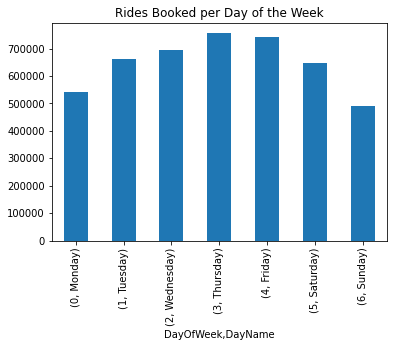

In [ ]:
uber_df.groupby(['DayOfWeek', 'DayName']).count().plot(kind='bar', y='Date/Time', legend=None, title='Rides Booked per Day of the Week')

We can see that most rides are booked on thursdays and fridays.

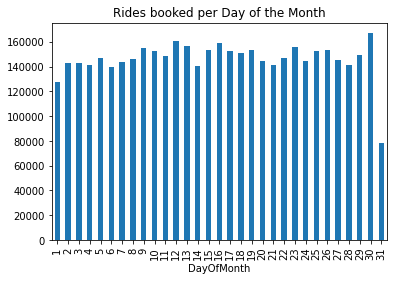

In [ ]:
uber_df.groupby('DayOfMonth').count().plot(kind='bar', y='Date/Time', legend=None, title='Rides booked per Day of the Month')

Also, the 30th of each month seems to see lots of ride bookings.

Over the months contained in the dataset, there is a steady upwards trend:

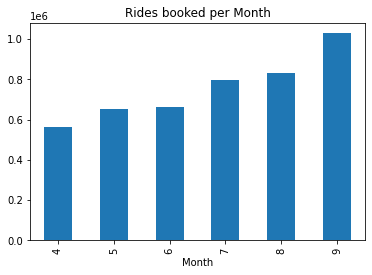

In [ ]:
uber_df.groupby('Month').count().plot(kind='bar', y='Date/Time', legend=None, title='Rides booked per Month')

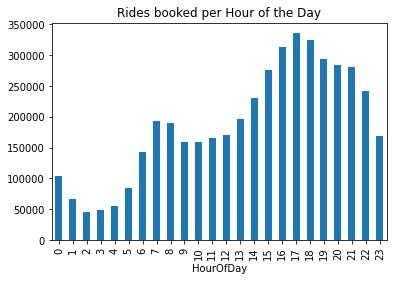

In [ ]:
uber_df.groupby('HourOfDay').count().plot(kind='bar', y='Date/Time', legend=None, title='Rides booked per Hour of the Day')

The most busy hours seem to be the time from 3pm to 9pm.

Let's check how this behaves for different days of the week:

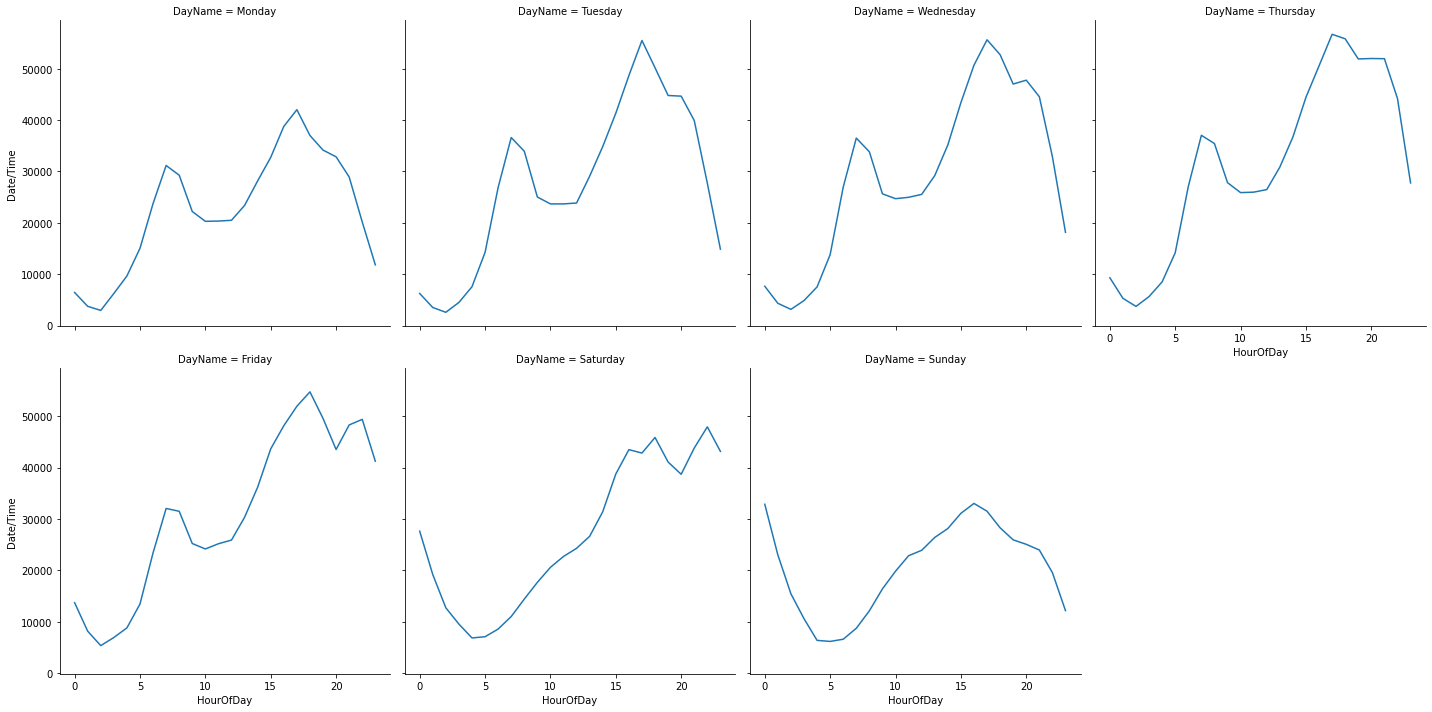

In [ ]:
rel = sns.relplot(kind='line', x='HourOfDay', y='Date/Time', col='DayName', col_wrap=4, data=uber_df.groupby(['DayOfWeek', 'DayName', 'HourOfDay']).count())

We can see that Monday to Thursday have a similar development over the day while friday and saturday have much more activity in the later hours. Sunday in general sees much fewer bookings. 

We can also look at this in a bar chart:

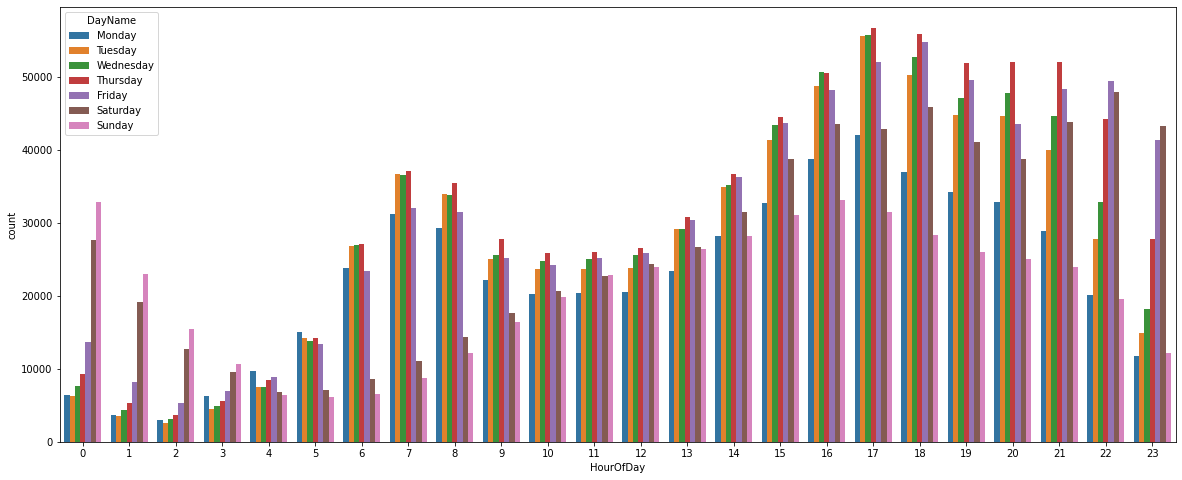

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(data=uber_df.sort_values(by='DayOfWeek'), x='HourOfDay', hue='DayName')

In the Uber dataset we have very detailed information on the pickup location. This allows us to plot these pickups on a world map.

For example, we might plot all pickups for a certain day like this:

In [ ]:
px.density_mapbox(
    uber_df[uber_df['Date/Time'].dt.date == uber_df.sample()['Date/Time'].dt.date.values[0]],
    lat="Lat",
    lon="Lon",
    radius=3,
    color_continuous_scale="reds",
    zoom=12,
    mapbox_style="carto-positron"
)

We can also plot these pickups over the time of day for a random day like this:

In [ ]:
dropdown = 'Saturday' #@param ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
subset_uber_df = uber_df[uber_df['Date/Time'].dt.date == uber_df[uber_df.DayName == dropdown].sample()['Date/Time'].dt.date.values[0]]
px.density_mapbox(
    subset_uber_df,
    lat="Lat",
    lon="Lon",
    radius=3,
    color_continuous_scale="reds",
    zoom=12,
    mapbox_style="carto-positron",
    animation_frame= subset_uber_df['Date/Time'].dt.strftime('%Y-%m-%dT%H'),
)

Lastly, we can of course also plot *all* of our 4.5 million datapoints. However, as this requires lots of computational power we instead generate a heatmap of the pickup locations:

In [ ]:
trans = Transformer.from_crs(
   "EPSG:4326", "EPSG:3857",
    always_xy=True,
)
uber_df["xx"], uber_df["yy"] = trans.transform(uber_df.Lon.values, uber_df.Lat.values)

In [ ]:
cvs = ds.Canvas(plot_width=10000, plot_height=10000)
red_merc = cvs.points(uber_df, x='xx', y='yy')
raw_img = transfer_functions.shade(red_merc, cmap=fire)

In [ ]:
display(transfer_functions.set_background(raw_img, 'black').to_pil())

We can also overlay this heatmap on a world map to see where the hotspots are located:

In [ ]:
red_latlon = cvs.points(uber_df, x='Lat', y='Lon')
# agg is an xarray object, see http://xarray.pydata.org/en/stable/ for more details
coords_lat, coords_lon = red_latlon.coords['Lat'].values, red_latlon.coords['Lon'].values
# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

img = raw_img[::-1].to_pil()


# Trick to create rapidly a figure with mapbox axes
fig = px.scatter_mapbox(uber_df[:1], lat='Lat', lon='Lon', zoom=12)
# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()

Clean up memory

In [ ]:
del cvs, red_merc, red_latlon

### Uber & Lyft

For our Uber & Lyft dataset, we could of course do similar analyses regarding the day of week, hour of day, etc. However, because we have additional data on weather available, it's much more interesting to see how weather impacts the number (and maybe prices) of pickups. 

In [ ]:
uber_lyft_df

datetime cab_type          name  price  distance  \
0      2018-12-16 09:30:07     Lyft        Shared    5.0      0.44   
1      2018-11-27 02:00:23     Lyft           Lux   11.0      0.44   
2      2018-11-28 01:00:22     Lyft          Lyft    7.0      0.44   
3      2018-11-30 04:53:02     Lyft  Lux Black XL   26.0      0.44   
4      2018-11-29 03:49:20     Lyft       Lyft XL    9.0      0.44   
...                    ...      ...           ...    ...       ...   
693065 2018-12-01 23:53:05     Uber           WAV    9.5      1.00   
693066 2018-12-01 23:53:05     Uber        UberXL   13.0      1.00   
693067 2018-12-01 23:53:05     Uber         UberX    9.5      1.00   
693069 2018-12-01 23:53:05     Uber     Black SUV   27.0      1.00   
693070 2018-12-01 23:53:05     Uber      UberPool   10.0      1.00   

        surge_multiplier  temperature  apparentTemperature  precipIntensity  \
0                    1.0        42.34                37.12           0.0000   
1                    1.0        43.58                37.35           0.1299   
2                    1.0        38.33                32.93           0.0000   
3                    1.0        34.38                29.63           0.0000   
4                    1.0        37.44                30.88           0.0000   
...                  ...          ...                  ...              ...   
693065               1.0        37.05                37.05           0.0000   
693066               1.0        37.05                37.05           0.0000   
693067               1.0        37.05                37.05           0.0000   
693069               1.0        37.05                37.05           0.0000   
693070               1.0        37.05                37.05           0.0000   

        windSpeed  uvIndex  DayOfWeek    DayName  DayOfMonth  HourOfDay  \
0            8.66        0          6     Sunday          16          9   
1           11.98        0          1    Tuesday          27          2   
2            7.33        0          2  Wednesday          28          1   
3            5.28        0          4     Friday          30          4   
4            9.14        0          3   Thursday          29          3   
...           ...      ...        ...        ...         ...        ...   
693065       2.34        0          5   Saturday           1         23   
693066       2.34        0          5   Saturday           1         23   
693067       2.34        0          5   Saturday           1         23   
693069       2.34        0          5   Saturday           1         23   
693070       2.34        0          5   Saturday           1         23   

        Month IsHoliday  
0          12     False  
1          11     False  
2          11     False  
3          11     False  
4          11     False  
...       ...       ...  
693065     12     False  
693066     12     False  
693067     12     False  
693069     12     False  
693070     12     False  

[637976 rows x 17 columns]

We first start by resampling our data on an hourly basis

In [ ]:
agg_dictf = dict.fromkeys(uber_lyft_df.select_dtypes(include=np.number).columns.tolist(), 'mean')

In [ ]:
agg_dictf['datetime'] = 'count'

In [ ]:
resampled_uber_lyft_df = uber_lyft_df.resample(rule='h', on='datetime').agg(agg_dictf).rename(columns={'datetime':'pickup_count'})

In [ ]:
resampled_uber_lyft_df

price  distance  surge_multiplier  temperature  \
datetime                                                                  
2018-11-26 03:00:00  18.694805  2.513896          1.032468        41.83   
2018-11-26 04:00:00  16.537179  2.179359          1.014103        41.52   
2018-11-26 05:00:00  16.482955  2.219773          1.017451        41.99   
2018-11-26 06:00:00  16.525992  2.154118          1.018468        41.83   
2018-11-26 07:00:00  16.249730  2.135362          1.008919        42.02   
...                        ...       ...               ...          ...   
2018-12-18 15:00:00  16.142188  2.120737          1.016091        27.41   
2018-12-18 16:00:00  16.618575  2.201449          1.008762        28.58   
2018-12-18 17:00:00  16.565129  2.247126          1.023072        30.78   
2018-12-18 18:00:00  16.865330  2.234350          1.016905        30.80   
2018-12-18 19:00:00  16.555651  2.377209          1.009418        32.34   

                     apparentTemperature  precipIntensity  windSpeed  uvIndex  \
datetime                                                                        
2018-11-26 03:00:00                41.83              0.0       0.51      0.0   
2018-11-26 04:00:00                41.52              0.0       0.45      0.0   
2018-11-26 05:00:00                41.99              0.0       0.53      0.0   
2018-11-26 06:00:00                41.83              0.0       1.83      0.0   
2018-11-26 07:00:00                42.02              0.0       2.01      0.0   
...                                  ...              ...        ...      ...   
2018-12-18 15:00:00                16.07              0.0      14.11      1.0   
2018-12-18 16:00:00                18.10              0.0      12.84      1.0   
2018-12-18 17:00:00                20.93              0.0      12.73      1.0   
2018-12-18 18:00:00                20.78              0.0      13.14      1.0   
2018-12-18 19:00:00                22.99              0.0      12.52      0.0   

                     DayOfWeek  DayOfMonth  HourOfDay  Month  pickup_count  
datetime                                                                    
2018-11-26 03:00:00        0.0        26.0        3.0   11.0            77  
2018-11-26 04:00:00        0.0        26.0        4.0   11.0           390  
2018-11-26 05:00:00        0.0        26.0        5.0   11.0           616  
2018-11-26 06:00:00        0.0        26.0        6.0   11.0          1462  
2018-11-26 07:00:00        0.0        26.0        7.0   11.0           925  
...                        ...         ...        ...    ...           ...  
2018-12-18 15:00:00        1.0        18.0       15.0   12.0          1709  
2018-12-18 16:00:00        1.0        18.0       16.0   12.0          1712  
2018-12-18 17:00:00        1.0        18.0       17.0   12.0          1712  
2018-12-18 18:00:00        1.0        18.0       18.0   12.0          1745  
2018-12-18 19:00:00        1.0        18.0       19.0   12.0           584  

[545 rows x 13 columns]

And then plot pairwise scatter plots to visualize the relationships between each pair of features:

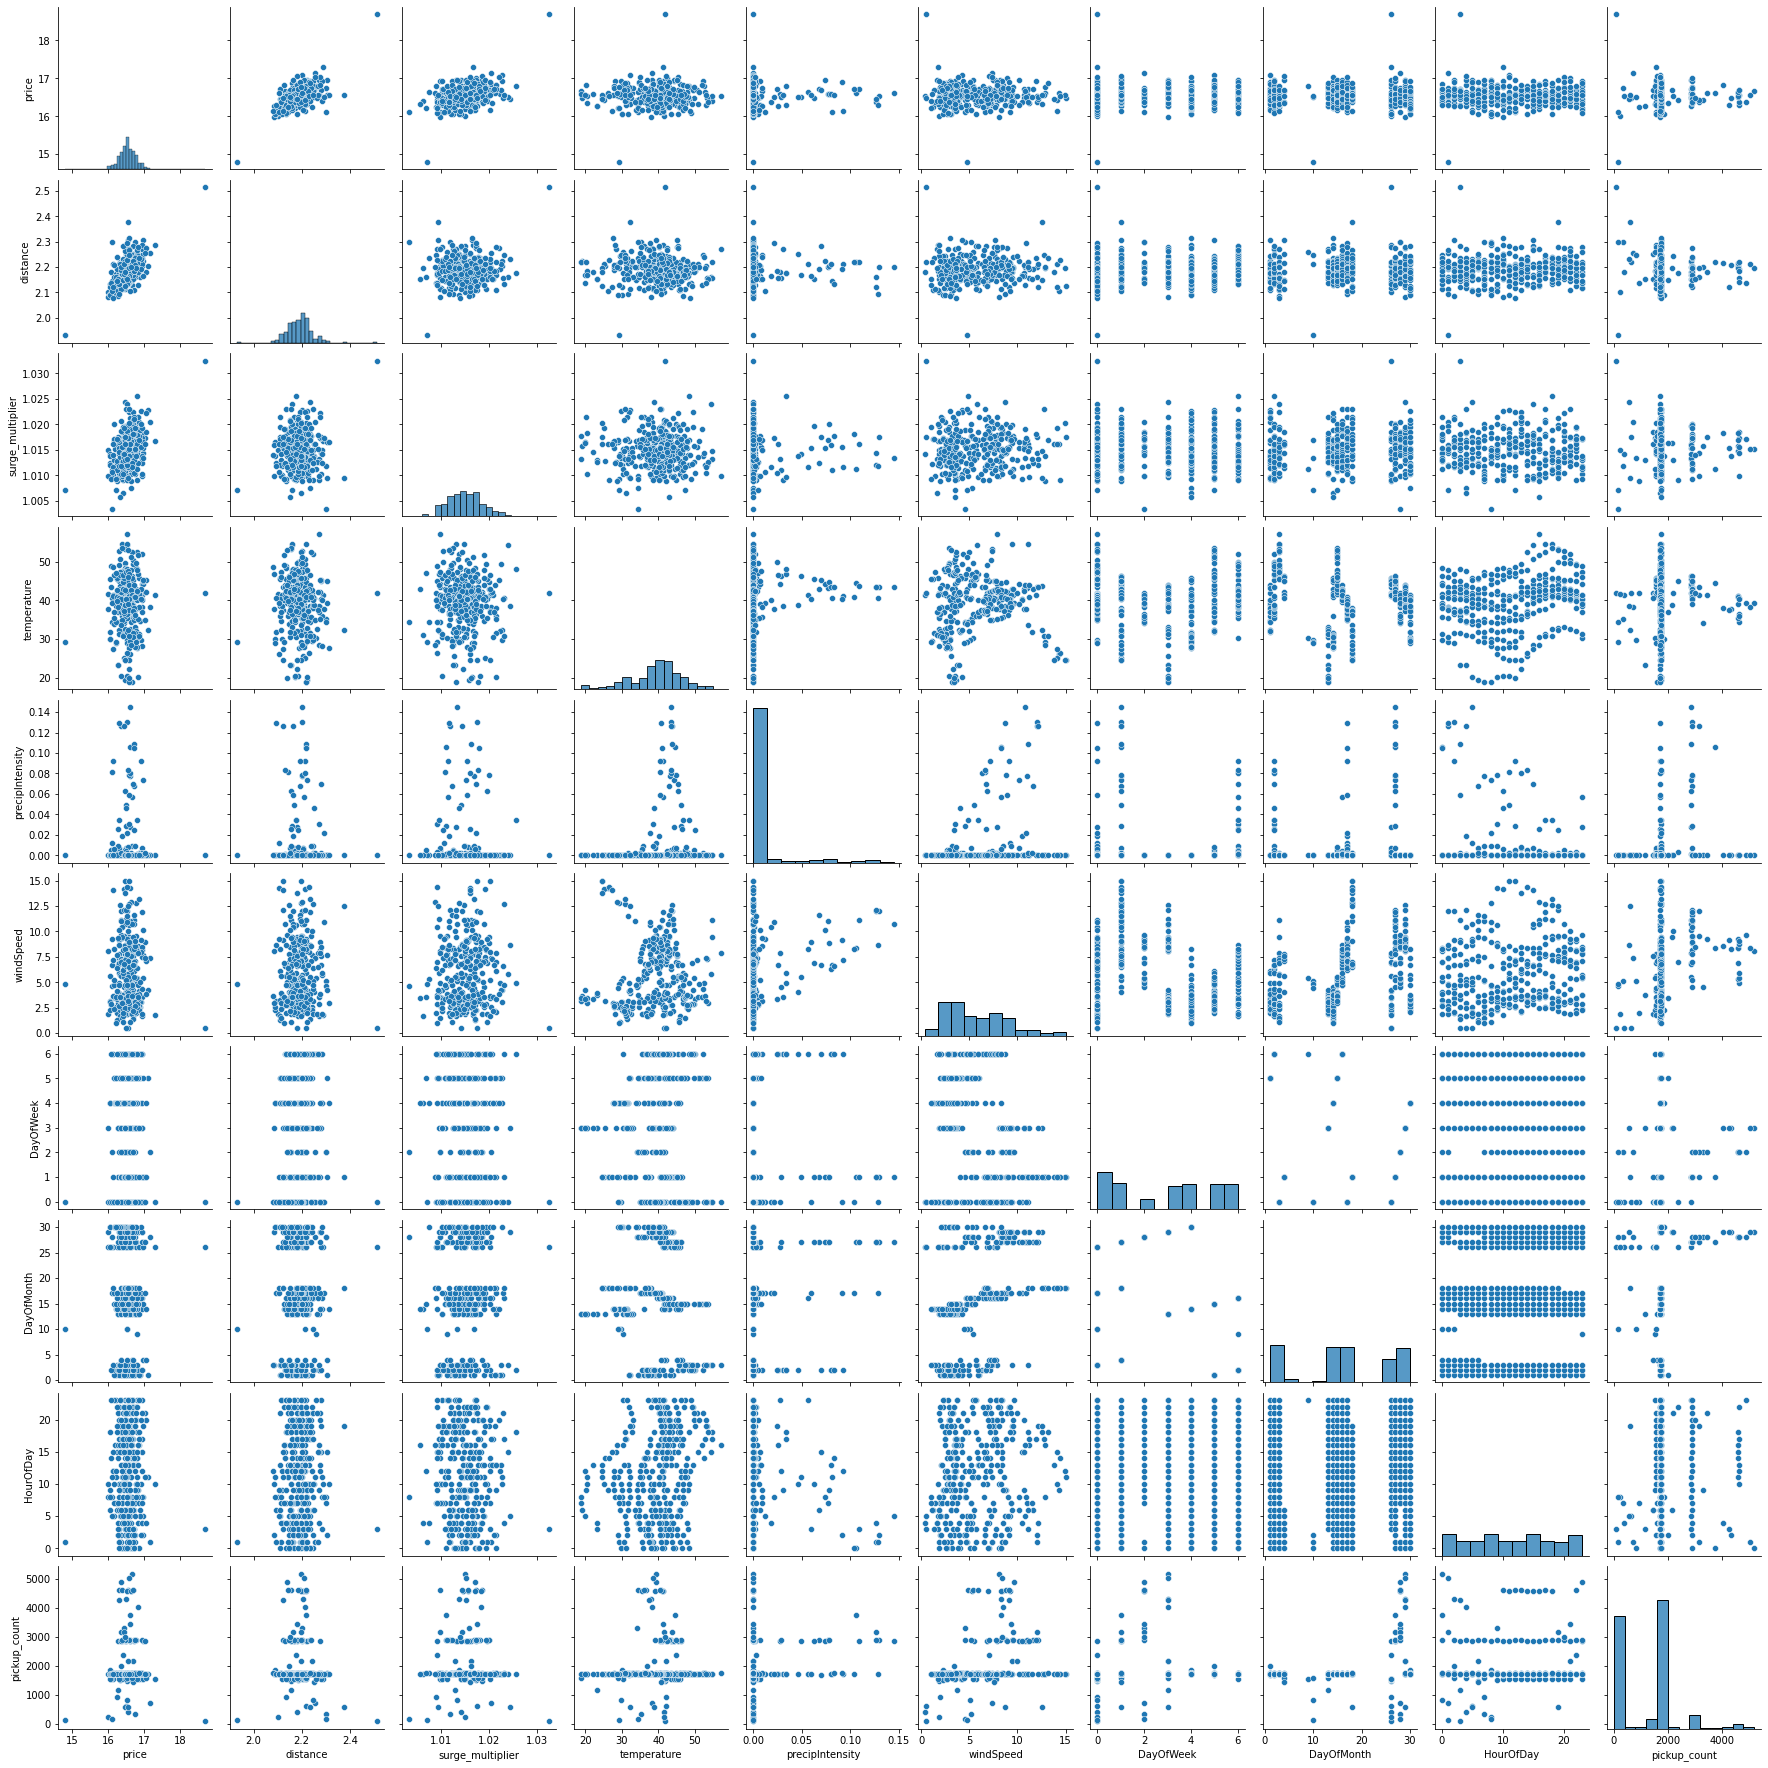

In [ ]:
sns.pairplot(resampled_uber_lyft_df.drop(columns=['apparentTemperature', 'uvIndex', 'Month']))

This plot is not very clear but we can already see here that the price has a positive correlation with `distance` and `surge_multiplier`.

We can take a closer look at this relation by creating a scatter plot with these two features on the x- and y-axis and the size and hue of points corresponding to the price:

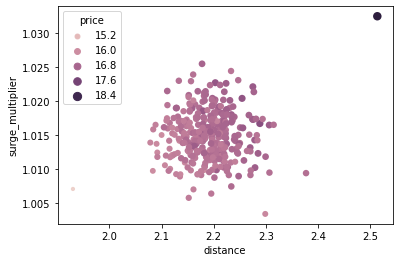

In [ ]:
sns.scatterplot(x="distance", y="surge_multiplier",
                hue="price", size="price", linewidth=0,
                data=resampled_uber_lyft_df)

The relation does not seem very clear, another way is to compute the correlation coefficients to check for relations that are strong:

In [ ]:
corr_mat = resampled_uber_lyft_df.corr().stack().reset_index(name="correlation")

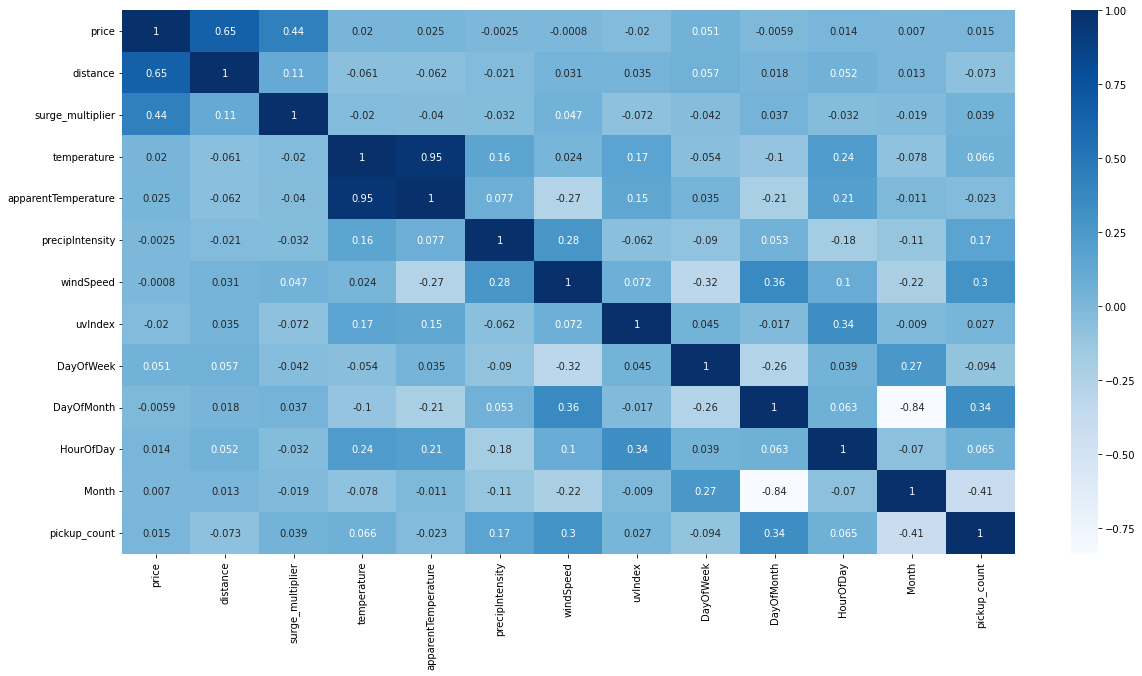

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap( resampled_uber_lyft_df.corr(), cmap="Blues", annot=True)

We don't seem to find any interesting correlation, except maybe that the number of pickups seems to increase with increasing wind speeds (correlation coefficient of 0.3). Also, we do find some obviously related features (e.g. `price`, `distance` and `surge_multiplier` or `windSpeed` and `apparentTemperature`).

# Price Prediction

Now that we have conducted some data cleansing and exploration steps, we can focus on our price prediction problem, i.e. we want to predict the prices for a ride based on the other features we have available. Because we want to predict a continuous variable (the price), this is a regression problem.

We start by removing some columns which were only interesting for the data exploration and dividing our data into the features (`X`) and target variable (`y`).

In [ ]:
sub_df = uber_lyft_df.drop(columns=['datetime','DayOfWeek', 'DayOfMonth', 'Month', 'IsHoliday']) # use subset: .sample(100000)
X = sub_df.drop(columns='price')
y = sub_df.price

Next, because we have some categorical data in our dataset, we will have to employ some one hot encodings:

In [ ]:
cols_to_ohe = ['cab_type', 'name', 'DayName']

In [ ]:
for col in cols_to_ohe:
  one_hot_cols = pd.get_dummies(X[col], prefix='col')
  X = pd.concat([X, one_hot_cols], axis=1)

In [ ]:
X = X.drop(columns=cols_to_ohe)

We now have individual columns describing which day the ride was booked and what vehicle/service type.

In [ ]:
X

distance  surge_multiplier  temperature  apparentTemperature  \
0           0.44               1.0        42.34                37.12   
1           0.44               1.0        43.58                37.35   
2           0.44               1.0        38.33                32.93   
3           0.44               1.0        34.38                29.63   
4           0.44               1.0        37.44                30.88   
...          ...               ...          ...                  ...   
693065      1.00               1.0        37.05                37.05   
693066      1.00               1.0        37.05                37.05   
693067      1.00               1.0        37.05                37.05   
693069      1.00               1.0        37.05                37.05   
693070      1.00               1.0        37.05                37.05   

        precipIntensity  windSpeed  uvIndex  HourOfDay  col_Lyft  col_Uber  \
0                0.0000       8.66        0          9         1         0   
1                0.1299      11.98        0          2         1         0   
2                0.0000       7.33        0          1         1         0   
3                0.0000       5.28        0          4         1         0   
4                0.0000       9.14        0          3         1         0   
...                 ...        ...      ...        ...       ...       ...   
693065           0.0000       2.34        0         23         0         1   
693066           0.0000       2.34        0         23         0         1   
693067           0.0000       2.34        0         23         0         1   
693069           0.0000       2.34        0         23         0         1   
693070           0.0000       2.34        0         23         0         1   

        ...  col_UberX  col_UberXL  col_WAV  col_Friday  col_Monday  \
0       ...          0           0        0           0           0   
1       ...          0           0        0           0           0   
2       ...          0           0        0           0           0   
3       ...          0           0        0           1           0   
4       ...          0           0        0           0           0   
...     ...        ...         ...      ...         ...         ...   
693065  ...          0           0        1           0           0   
693066  ...          0           1        0           0           0   
693067  ...          1           0        0           0           0   
693069  ...          0           0        0           0           0   
693070  ...          0           0        0           0           0   

        col_Saturday  col_Sunday  col_Thursday  col_Tuesday  col_Wednesday  
0                  0           1             0            0              0  
1                  0           0             0            1              0  
2                  0           0             0            0              1  
3                  0           0             0            0              0  
4                  0           0             1            0              0  
...              ...         ...           ...          ...            ...  
693065             1           0             0            0              0  
693066             1           0             0            0              0  
693067             1           0             0            0              0  
693069             1           0             0            0              0  
693070             1           0             0            0              0  

[637976 rows x 29 columns]

Next, we split our data into train and test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)

We are now ready to train some machine learning models. Let's start with a simple decision tree:

## Decision Tree

We initialize and fit the tree on our train dataset:

In [ ]:
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

And then score it on our test dataset:

In [ ]:
regressor.score(X_test, y_test)

0.9379038013267098

The model achieves an $R^2$ score of 93.8% which is quite strong (100% are perfect predictions).

We can also have a look at some other metrics:

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
mean_absolute_error(y_test, y_pred)

1.4150687753313087


Note that the MAE is in the same unit as the original data, so this means on average the model is around $1.4 off.

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

0.1036031261793845

The MAPE score shows that our model is off by around 10.4% - pretty good.

One advantage of decision trees is that you can plot them to see which features are important for predicting the prices:

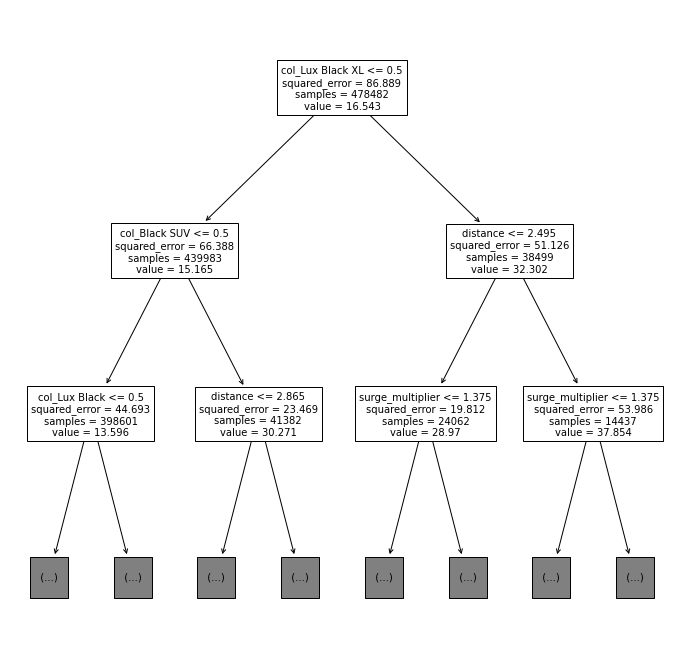

In [ ]:
plt.figure(figsize=(12,12)) 
plot_tree(regressor, max_depth=2, fontsize=10, feature_names=X_train.columns);

As can be seen from the plot, one major influence on the price appears to be the type of car/service booked, the distance, and the `surge_multiplier` feature - all expected.

## Deep Neural Network

The decision tree we trained above performed quite well - let's see what a deep neural network can do.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We start by defining our model:

In [ ]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
  return model

Let's then build and compile our model:

In [ ]:
model = build_and_compile_model()

We define an early stopping callback so that training does not continue when the model does not improve further:

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.01, patience=5, restore_best_weights=True)

Finally, let's train our model:

In [ ]:
history = model.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping],
    verbose=2, epochs=100)

Epoch 1/100
14953/14953 - 43s - loss: 4.2204 - val_loss: 3.8258 - 43s/epoch - 3ms/step
Epoch 2/100
14953/14953 - 39s - loss: 3.6200 - val_loss: 3.8108 - 39s/epoch - 3ms/step
Epoch 3/100
14953/14953 - 37s - loss: 3.5574 - val_loss: 3.6840 - 37s/epoch - 2ms/step
Epoch 4/100
14953/14953 - 37s - loss: 3.5360 - val_loss: 3.5207 - 37s/epoch - 3ms/step
Epoch 5/100
14953/14953 - 37s - loss: 3.5259 - val_loss: 3.5399 - 37s/epoch - 3ms/step
Epoch 6/100
14953/14953 - 40s - loss: 3.5153 - val_loss: 3.4412 - 40s/epoch - 3ms/step
Epoch 7/100
14953/14953 - 40s - loss: 3.5099 - val_loss: 3.3817 - 40s/epoch - 3ms/step
Epoch 8/100
14953/14953 - 38s - loss: 3.5040 - val_loss: 3.5078 - 38s/epoch - 3ms/step
Epoch 9/100
14953/14953 - 37s - loss: 3.5024 - val_loss: 3.4336 - 37s/epoch - 3ms/step
Epoch 10/100
14953/14953 - 38s - loss: 3.4896 - val_loss: 3.4723 - 38s/epoch - 3ms/step
Epoch 11/100
14953/14953 - 37s - loss: 3.4834 - val_loss: 3.5383 - 37s/epoch - 2ms/step
Epoch 12/100
14953/14953 - 40s - loss: 3.

We're using a fairly simple neural network with two hidden layers and the following architecture:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1920      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,145
Trainable params: 6,145
Non-trainable params: 0
_________________________________________________________________


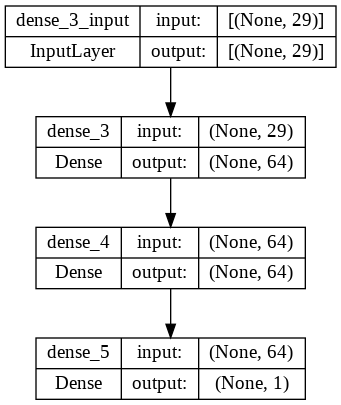

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

We can check the performance by calculating the $R^2$ score:

In [ ]:
y_pred = model.predict(X_test_scaled)

4985/4985 [==============================] - 8s 1ms/step


In [ ]:
r2_score(y_test, y_pred)

0.9612740956472192

96% is quite strong, also better than the decision tree.

We can also plot the training and validation loss over time during training like this:

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([3,5])
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()

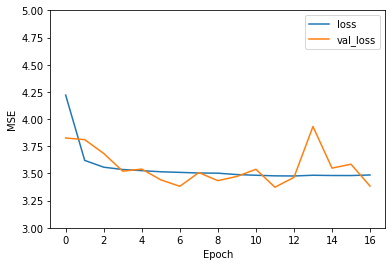

In [ ]:
plot_loss(history)

As can be seen, training appears to be somewhat unstable. However, this might be caused by the fact that the model perfoms very well in general so that small variations in the training data can offset the MSE quite significantly.

We can also plot the probability distribution for the actual and predicted values using KDE:

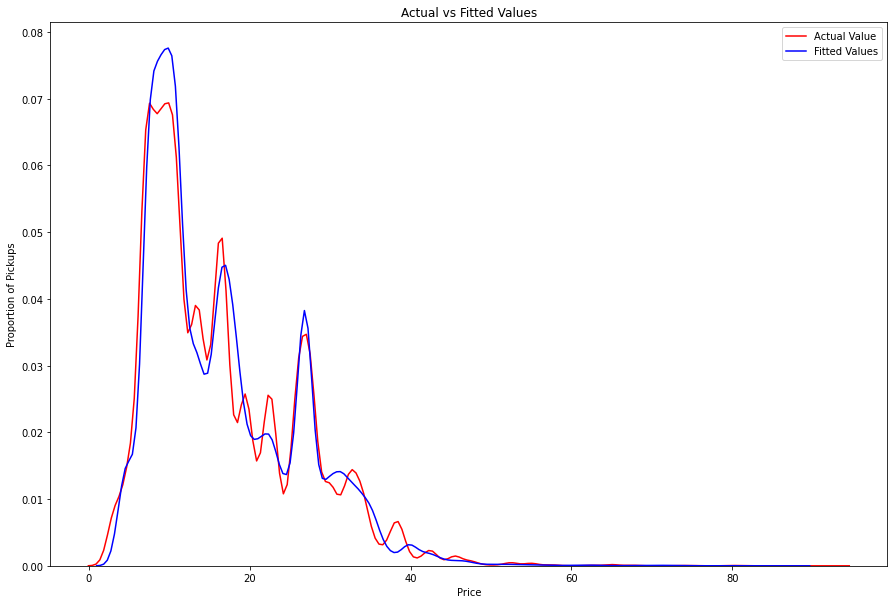

In [ ]:
plt.figure(figsize=(15, 10))
ax1 = sns.kdeplot(y_test, color="r", label="Actual Value")
sns.kdeplot(np.squeeze(y_pred), color="b", label="Fitted Values", ax=ax1)
plt.legend()
plt.title('Actual vs Fitted Values')
plt.xlabel('Price')
plt.ylabel('Proportion of Pickups')
plt.show()

We see that our model is quite close to the actual distribution.

To conduct some simple error analysis, we first add back the actual and predicted prices to the dataframe:

In [ ]:
error_analysis_df = X_test.copy()
error_analysis_df['actual_price'] = y_test
error_analysis_df['predicted_price'] = y_pred

Then, we compute the residual using the MSE score:

In [ ]:
error_analysis_df['residual'] = (error_analysis_df.actual_price-error_analysis_df.predicted_price)**2

We can then sort by the residual and retrieve the first 10 rows:

In [ ]:
error_analysis_df.sort_values(by='residual', ascending=False).head(10)

distance  surge_multiplier  temperature  apparentTemperature  \
164401      7.46               1.0        41.46                39.41   
658443      3.07               1.0        35.95                30.89   
2686        3.23               1.0        36.89                34.35   
510312      2.32               1.0        31.80                31.80   
283119      0.62               1.0        37.71                31.92   
119248      1.35               1.0        40.78                36.05   
146569      3.37               1.0        31.71                22.64   
128002      0.72               1.0        31.54                31.54   
686590      1.89               1.0        34.87                28.73   
565391      3.61               1.0        42.50                36.47   

        precipIntensity  windSpeed  uvIndex  HourOfDay  col_Lyft  col_Uber  \
164401           0.0000       3.57        1         17         0         1   
658443           0.0000       6.06        1         13         0         1   
2686             0.0000       3.41        0          2         0         1   
510312           0.0000       2.10        0         13         0         1   
283119           0.0000       7.78        1         17         0         1   
119248           0.0000       7.06        0         19         0         1   
146569           0.0025      11.52        0          7         0         1   
128002           0.0000       2.11        0          2         0         1   
686590           0.0023       7.37        0         11         0         1   
565391           0.0000      10.68        0         20         0         1   

        ...  col_Friday  col_Monday  col_Saturday  col_Sunday  col_Thursday  \
164401  ...           1           0             0           0             0   
658443  ...           0           0             1           0             0   
2686    ...           0           0             1           0             0   
510312  ...           1           0             0           0             0   
283119  ...           0           1             0           0             0   
119248  ...           0           1             0           0             0   
146569  ...           0           0             0           0             0   
128002  ...           1           0             0           0             0   
686590  ...           0           1             0           0             0   
565391  ...           0           0             0           0             1   

        col_Tuesday  col_Wednesday  actual_price  predicted_price     residual  
164401            0              0          89.5        47.092148  1798.425926  
658443            0              0          58.0        18.670387  1546.818438  
2686              0              0          56.0        18.987343  1369.936790  
510312            0              0          65.0        29.283432  1275.673229  
283119            0              0          61.5        27.070267  1185.406533  
119248            0              0          60.5        26.463539  1158.480669  
146569            1              0          58.0        25.383442  1063.839861  
128002            0              0          59.0        26.738178  1040.825142  
686590            0              0          47.0        15.070926  1019.465785  
565391            0              0          67.0        35.834763   971.272024  

[10 rows x 32 columns]

Unfortunately, the pairplot does not reveal any interesting correlations between the residual and any specific feature:

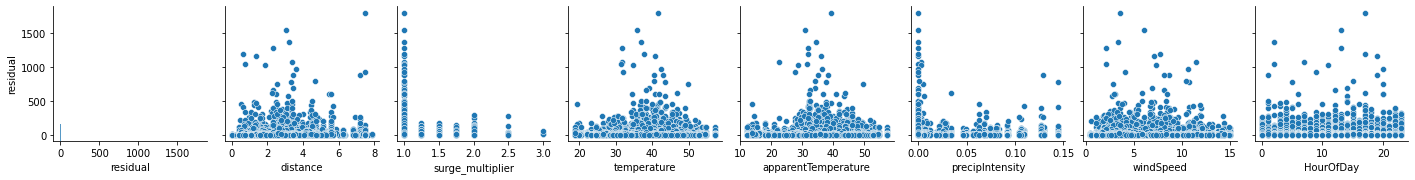

In [ ]:
sns.pairplot(error_analysis_df[['residual','distance', 'surge_multiplier', 'temperature', 'apparentTemperature', 'precipIntensity', 'windSpeed', 'HourOfDay']], y_vars=['residual'])

Also the correlation heatmap does not give any insights into which rides the model has a worse price prediction performance for.

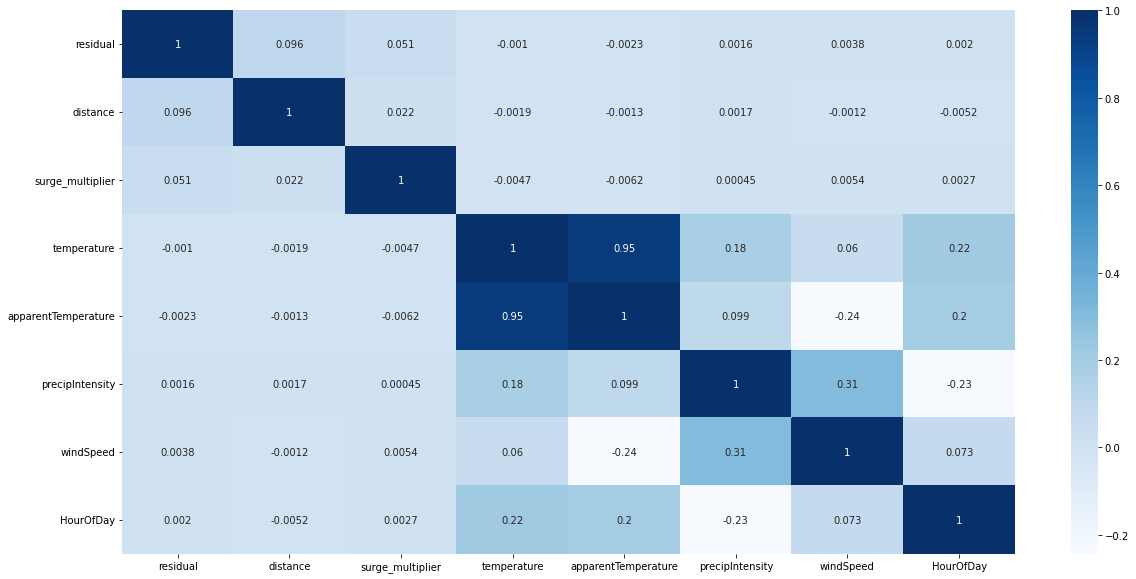

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(error_analysis_df[['residual','distance', 'surge_multiplier', 'temperature', 'apparentTemperature', 'precipIntensity', 'windSpeed', 'HourOfDay']].corr(), cmap="Blues", annot=True)

This conducts our Uber & Lyft data exploration and price prediction session.

Thanks for your attention!

![XKCD 1838](https://imgs.xkcd.com/comics/machine_learning.png)